Вот он родимый. На нем сегодня будем учиться.  
В этой тетрадке будем рассматривать только столбец температуры.

In [1]:
!kaggle datasets download sumanthvrao/daily-climate-time-series-data -p data -o --unzip

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 42.3MB/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from scipy import stats
import tensorflow as tf
from itertools import product
from sklearn.metrics import mean_squared_error
%matplotlib inline

Будем погружаться постепенно. Начнем с помесячного прогноза. Так и данных меньше, и сезонность равна целому числу - 12 месяцам.

In [3]:
df = pd.read_csv('data/DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')
df = df.resample('M').mean()
print(df.shape)
df.head(3)

(49, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-31,12.074770,73.028802,4.833913,1017.847734
2013-02-28,16.867560,71.938563,7.474090,1015.946003
2013-03-31,22.814209,57.417243,8.757270,1011.733909


Для того, чтобы _ARIMA_ мог нормально предсказывать, необходимо сделать ряд стационарным. Критерий Дики-Фуллера отвечает за проверку ряда на стационарность. Если p-value этого критерия меньше, чем $\alpha=0.05$, то ряд стационарен.

Критерий Дики-Фуллера: p=0.7360


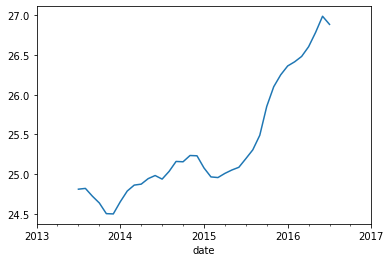

In [4]:
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(df.meantemp)[1]:.4f}')
sm.tsa.seasonal_decompose(df.meantemp).trend.plot()
plt.show()

В нашем случае исходный ряд не стационарен. Поэтому проведем сезонное дифференцирование.  
Также я построил тренд нашего ряда. По-хорошему, нужно сделать так, чтобы тренд не имел в себе никакой информации - превратить его в белый шум. Но пока что он выглядит как лицо в профиль.

Критерий Дики-Фуллера: p=0.0006


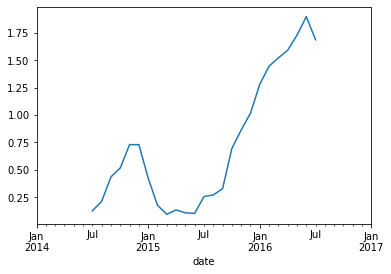

In [5]:
df['meantemp_shift12'] = df.meantemp - df.meantemp.shift(12)
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(df.meantemp_shift12[12:])[1]:.4f}')
sm.tsa.seasonal_decompose(df.meantemp_shift12[12:]).trend.plot()
plt.show()

Что ж, критерий Дики-Фуллера говорит, что ряд можно считать стационарным. И хоть тренд еще не выглядит как белый шум, он уже не выглядит как лицо.  

Ладно, шутки шутками, но данных мало и еще одно дифференцирование я лучше не буду проводить. Вы можете попробовать.

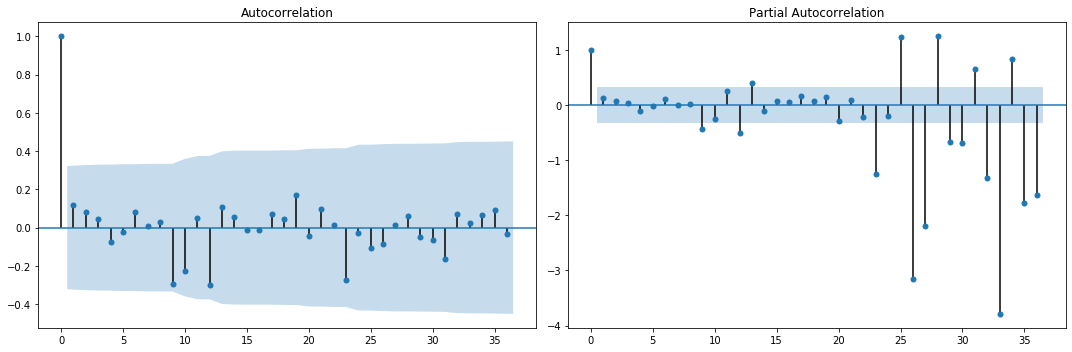

In [6]:
plt.figure(figsize=[15, 5])
ax = plt.subplot(121)
sm.graphics.tsa.plot_acf(df.meantemp_shift12[12:].values, lags=36, ax=ax)
ax = plt.subplot(122)
sm.graphics.tsa.plot_pacf(df.meantemp_shift12[12:].values, lags=36, ax=ax)
plt.tight_layout()
plt.show()

А что это у нас тут такое? А это коррелограммы. Первый график - график автокорреляции. По нему можно определить значения _q_ и _Q_. Второй - график частичной автокорреляции. Нужен для определения _p_ и _P_.  
Маленькие _p_ и _q_ определяются последним значемым лагом с позицией от 1 до _S_ (в нашем случае _S_=12(мес.)). Большие _P_ и _Q_ определяются последним значемым лагом с позицией кратной *S* - 12, 24 и т.д.  

За начальные приближения по графикам стоит взять *p = 0* , *q = 0*, *P = 3*, *Q = 0*. Но мы же понимаем, что крайне маловероятно, что значения температуры в следующий месяц зависят только от этих же месяцев один, два и три года назад. Поэтому зададим некоторый интервал около начальных значение _p_, _q_, _P_ и _Q_ и посмотрем, какая модель будет лучше.

Также, так как было одно сезонное дифференцирование _D = 1_. И так как обычных дифференцирований не было _d = 0_.

In [7]:
ps = range(2)
d = 0
qs = range(2)
Ps = range(4)
D = 1
Qs = range(2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

32


А теперь будем брутфорсом выбирать нужную модель. Но по какому параметру нужно это делать?  
Если выбрать в качестве такого параметра правдоподобие, то алгоритм просто возьмет наибольшее количество параметров _p_, _q_, _P_ и _Q_ и переобучится. 

Поэтому будем выбирать лучшую модель по критерию Акаике. 

$AIC = -2ln(L) + 2 * (p + q + P + Q + 1)$

In [8]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.arima.ARIMA(
            df.meantemp, 
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit()
    except Exception:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([f'SARIMA({param[0]}, 0, {param[1]})x({param[2]}, 1, {param[3]}, 12)', model.aic])

Wall time: 13.2 s


Вот так выглядит модель с наименьшим _AIC_.

In [9]:
print(best_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         meantemp   No. Observations:                   49
Model:             ARIMA(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -71.011
Date:                          Mon, 04 May 2020   AIC                            148.022
Time:                                  22:03:45   BIC                            152.854
Sample:                              01-31-2013   HQIC                           149.725
                                   - 01-31-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5317      0.127      4.173      0.000       0.282       0.781
ar.S.L12      -0.6537      0.248     -2.637      0.

Однако, наличие наименьшего _AIC_ не всегда говорит о том, что модель действительно является лучшей. Поэтому, стоит также рассмотреть другие модели, у которых AIC отличается не очень сильно.

In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['Model', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Model,AIC
14,"SARIMA(1, 0, 0)x(1, 1, 0, 12)",148.021672
13,"SARIMA(1, 0, 0)x(0, 1, 1, 12)",148.279616
15,"SARIMA(1, 0, 0)x(1, 1, 1, 12)",148.599404
16,"SARIMA(1, 0, 0)x(2, 1, 0, 12)",149.009504
18,"SARIMA(1, 0, 0)x(3, 1, 0, 12)",149.958954


В принципе, отличие в 0.15 между первой и второй моделью выглядит небольшим. Но Там выше _Q_ и наже _P_. Логично будет предположить, что такая модель будет хуже работать, потому что изначальный временной ряд и так был сжат до помесячного, из-за чего наличие ошибки в каждом значении в теории уменьшилось. Так что я не буду рассматривать вторую вторую модель, но вы можете.  

Третья выглядит интересно, и ее я бы порекомендовал самостоятельно изучить. Эта тетрадка и без нее будет очень длинной.

Важный элемент работы с моделями _ARIMA_ - это оценка остатков. Они должны быть:
  - не смещенны;
  - стационарны;
  - неавтокоррелированы.

Если один из пунктов не выполнен - в остатках есть какая-то закономерность, которую наш алгоритм на нашел.

Сейас мы это проверим. Критерий Стьюдента отвечает за оценку смещенности - если p-value больше $\alpha=0.05$, ряд не смещен. С критерием Дики-Фуллера я вас уже знакомил.

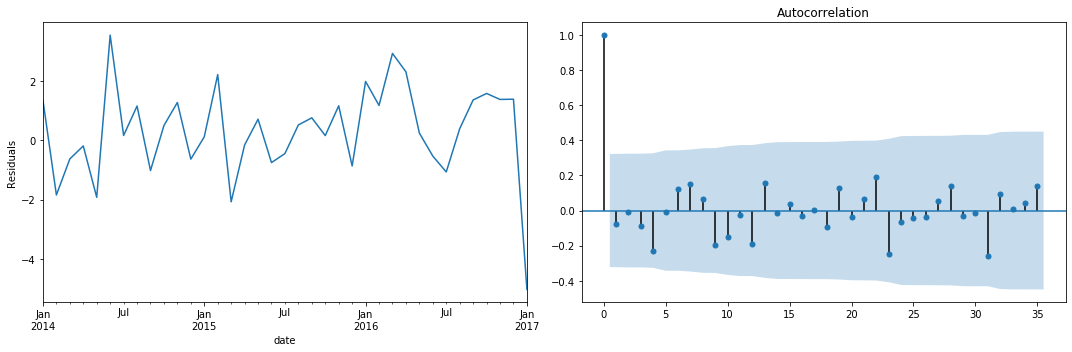

Критерий Стьюдента: p-value=0.246604
Критерий Дики-Фуллера: p-value=0.000003


In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(122)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=35, ax=ax)
plt.tight_layout()
plt.show()

print("Критерий Стьюдента: p-value=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p-value=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Вот так выглядит график остатков. Он не смещен, стационарен и неавтокоррелирован.

Может показаться, что ряд смещен, ведь p < 0.5. Но вероятность и p-value - это абсолютно разные вещи. Даже если, p-value равен 0.06, вероятность того, что он не смещен, гораздо больше 0.06. Так что смотря на p-value, просто сравнивайте его с $\alpha$.

Построим изначальный временной ряд, и временной ряд, описанный нашей моделью.

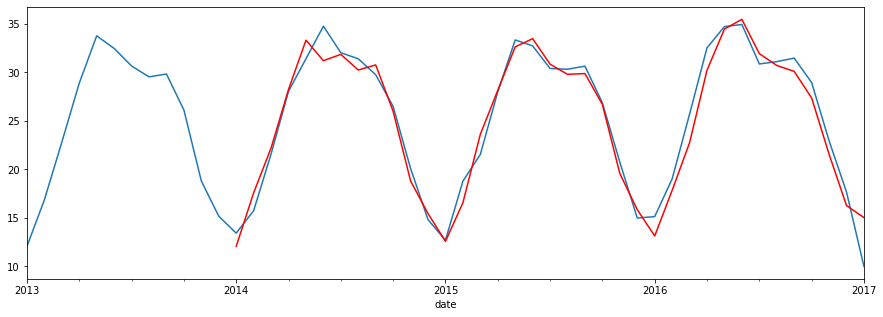

In [12]:
plt.figure(figsize=(15,5))
df.meantemp.plot()
best_model.fittedvalues[12:].plot(color='r')
plt.show()

Выглядит относительно точно. Не стоит ждать в предсказаниях временных рядов какой-то огромной точности.  

Займемся проверкой на тестовой выборке.

In [13]:
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', parse_dates=['date'], index_col='date')
df_test = df_test.resample('M').mean()

y_test = df_test.meantemp
y_pred = best_model.predict(start=df_test.index.min(), end=df_test.index.max())

Посмотрим, как выглядят тестовые и предсказанные данные. И заодно проверим, какая среднеквадратичная ошибка у них.

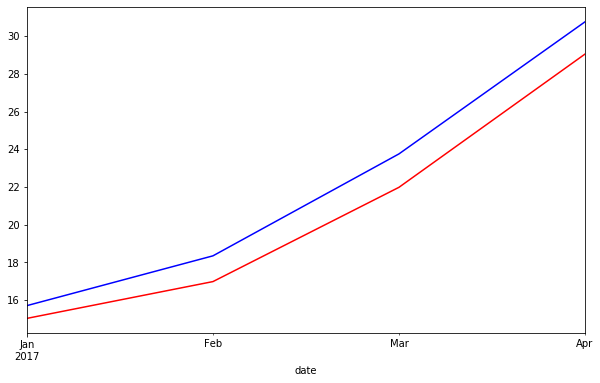

MSE = 2.0957493335106343


In [14]:
plt.figure(figsize=[10, 6])
df_test.meantemp.plot(c='b')
y_pred.plot(c='r')
plt.show()
print(f'MSE = {mean_squared_error(y_test, y_pred)}')

Вау, мы будто построили идеальную модель. *MSE = 2.096*, это ж подумать только.  

Ну, на самом деле, если говорить о средней температуре в месяц, то модель справляется действительно неплохо.  

Но представим ситуацию, где вас - начинающего и способного предсказывать только среднемесячную температуру - наняли жадные до денег метеорологи. Какая будет ошибка, если считать по дням?

In [15]:
def get_true_y_pred(y_test, y_pred):
    y_tmp = y_pred.resample('BMS').mean()
    index = list(y_tmp.index)
    index[0] = y_test.index.min()
    y_tmp.index = index
    y_tmp.loc[y_test.index.max()] = y_tmp.iloc[-1]
    return y_tmp.resample('D').pad()

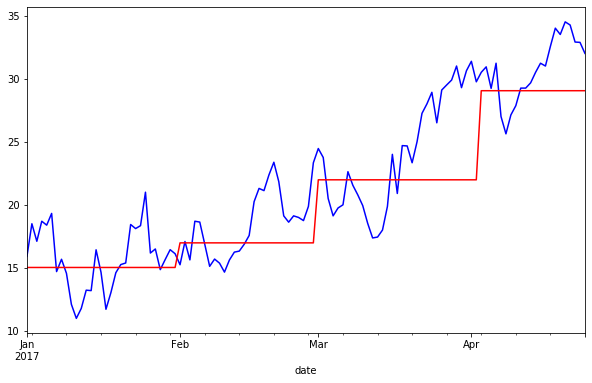

MSE = 12.483974067999617


In [16]:
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', parse_dates=['date'], index_col='date')

y_test = df_test.meantemp
y_pred = get_true_y_pred(y_test, y_pred)

plt.figure(figsize=[10, 6])
df_test.meantemp.plot(c='b')
y_pred.plot(c='r')
plt.show()

print(f'MSE = {mean_squared_error(y_test, y_pred)}')

Уф, как больно. Это отклонение гораздо больше. Конечно, можно по другому приближать данные - не ступенькообразно. Но все равно разница большая. 

Тогда может начать предсказывать температуру по дням? Да, думаю, стоит. Но давайте, порассуждаем. Какая сезонность будет у таких данных? Год, определенно год. Сколько дней в году? Ну, 365 чаще, чем 366. Но в теории, брать 365 дней не совсем правильно, а взять 365.25 - невозможно.

Ну ладно, возьмем 365, станем плохими парнями. Теперь все хорошо? Ну, в теории... Вот как выглядит алгоритм SARIMA (ARIMA с сезонным дифференцированием):

$y_t = \alpha + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_py_{t-p} + \\
\qquad \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + ... + \theta_q\varepsilon_{t-q} + \\
\qquad  \phi_{1S}y_{t-1S} + \phi_{2S}y_{t-2S} + ... + \phi_{PS}y_{t-PS} + \\
\qquad \theta_{1S}\varepsilon_{t-1S} + \theta_{2S}\varepsilon_{t-2S} + ... + \theta_{QS}\varepsilon_{t-QS} $

В общем-то по этому в формуле _AIC_ присутствует *p + q + P + Q + __1__*, 1 - это $\alpha$. 

Так и к чему это я. Математически с ростом числа _S_ - нашего периода сезона, наши модели не будут меняться. Но, с ростом _S_ скорость работы _ARIMA_ падает нелинейно. Если вам и хватит памяти, ждать, пока _ARIMA_ построит модель с *S=365*, вы устанете.

Предлагаю алтернативу. Сделаем те же самые расчеты с средненедельной температурой. Тогда период будет *365.25/7*, что примерно равно 52.

Критерий Дики-Фуллера: p=0.0001


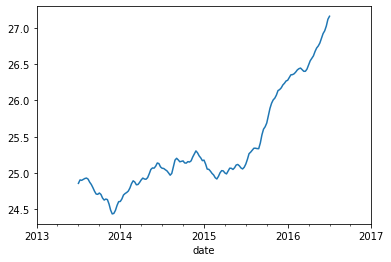

In [17]:
df = pd.read_csv('data/DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')
df = df.resample('W').mean()

print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(df.meantemp)[1]:.4f}')
sm.tsa.seasonal_decompose(df.meantemp).trend.plot()
plt.show()

Ух-ты, этот ряд уже стационарен. Но теперь нам ничего не мешает избавиться от тренда.

Критерий Дики-Фуллера: p=0.0173


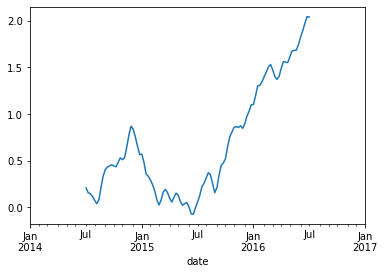

In [18]:
df['meantemp_shift52'] = df.meantemp - df.meantemp.shift(52)
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(df.meantemp_shift52[52:])[1]:.4f}')
sm.tsa.seasonal_decompose(df.meantemp_shift52[52:]).trend.plot()
plt.show()

Ряд все еще стационарен, но линия тренда теперь выглядит получше. Давайте на всякий случай произведем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.0000


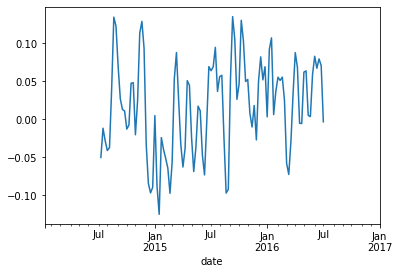

In [19]:
df['meantemp_shift53'] = df.meantemp_shift52 - df.meantemp_shift52.shift(1)
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(df.meantemp_shift53[53:])[1]:.4f}')
sm.tsa.seasonal_decompose(df.meantemp_shift53[53:]).trend.plot()
plt.show()

Смотрите-ка, он теперь мегастационарен <small>(кто учится в ИТМО, поймет)</small>. 

И тренд теперь выглядит как белый шум.

Итак, запомнили - мы проверили 1 сезонное дифференцирование (_D = 1_) и 1 обычное (_d = 1_).

Снова построим коррелограммы. Если строить 52+ лага на одной коррелограмме, ничего не будет понятно. Поэтому я построил по две для автокорреляции и частичной автокорреляции.

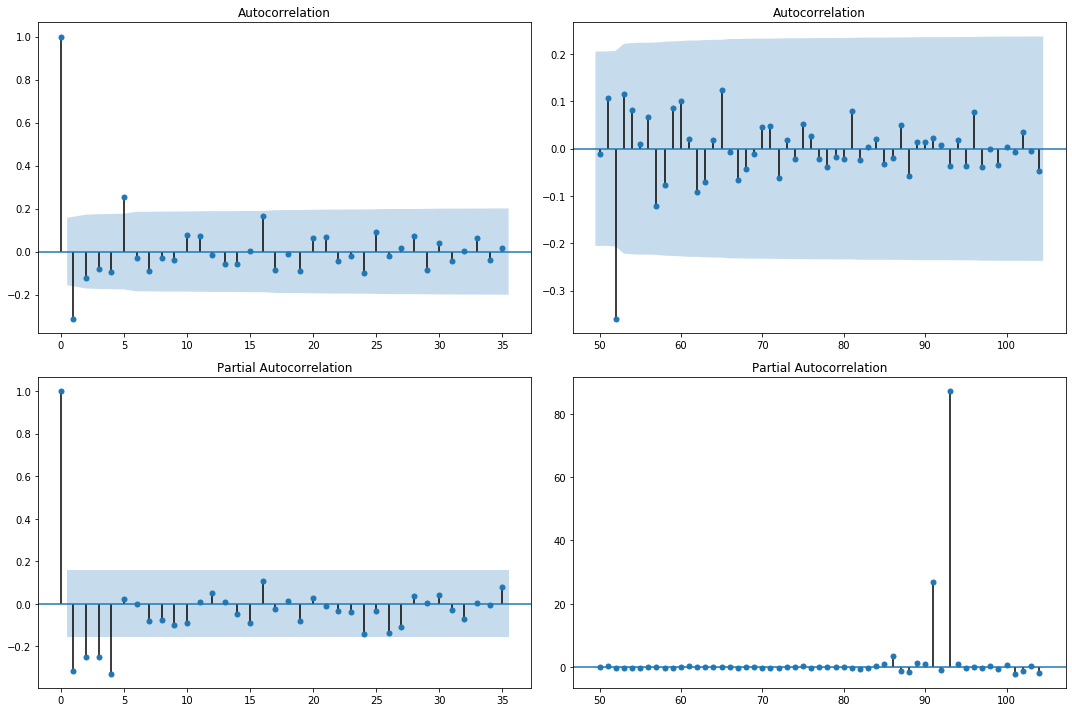

In [20]:
plt.figure(figsize=[15, 10])
ax = plt.subplot(221)
sm.graphics.tsa.plot_acf(df.meantemp_shift53[53:].values, lags=35, ax=ax)
ax = plt.subplot(222)
sm.graphics.tsa.plot_acf(df.meantemp_shift53[53:].values, lags=range(50, 105), ax=ax)
ax = plt.subplot(223)
sm.graphics.tsa.plot_pacf(df.meantemp_shift53[53:].values, lags=35, ax=ax)
ax = plt.subplot(224)
sm.graphics.tsa.plot_pacf(df.meantemp_shift53[53:].values, lags=range(50, 105), ax=ax)
plt.tight_layout()
plt.show()

Начальные приближения: _p = 4_, _q = 2_, _P = ?_, _Q = 1_.

Данные ведут себя немножко странно, поэтому на глаз определить начальное приближение _P_ не удалось.

In [21]:
ps = range(5)
d = 1
qs = range(3)
Ps = range(3)
D = 1
Qs = range(2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

90


In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.arima.ARIMA(
            df.meantemp, 
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 52)
        ).fit(method='innovations_mle', low_memory=True, cov_type='none')
    except Exception:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([f'SARIMA({param[0]}, 0, {param[1]})x({param[2]}, 1, {param[3]}, 52)', model.aic])

Wall time: 1min 29s


Как я и говорил, это занимает гораздо больше времени. 

In [23]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          meantemp   No. Observations:                  209
Model:             ARIMA(1, 1, 1)x(2, 1, [], 52)   Log Likelihood                -321.657
Date:                           Mon, 04 May 2020   AIC                            653.315
Time:                                   22:45:08   BIC                            668.564
Sample:                               01-06-2013   HQIC                           659.508
                                    - 01-01-2017                                         
Covariance Type:                            none                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3117        nan        nan        nan         nan         nan
ma.L1         -0.9327        nan        nan

In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['Model', 'AIC']
print(result_table.sort_values(by = 'AIC', ascending=True).head())

                            Model         AIC
14  SARIMA(1, 0, 1)x(2, 1, 0, 52)  653.314864
8   SARIMA(0, 0, 2)x(2, 1, 0, 52)  653.958615
23  SARIMA(2, 0, 1)x(2, 1, 0, 52)  655.304957
17  SARIMA(1, 0, 2)x(2, 1, 0, 52)  655.307804
32  SARIMA(3, 0, 1)x(2, 1, 0, 52)  656.689159


Третья выглядит интересно, но, опять же, оставлю ее вам.

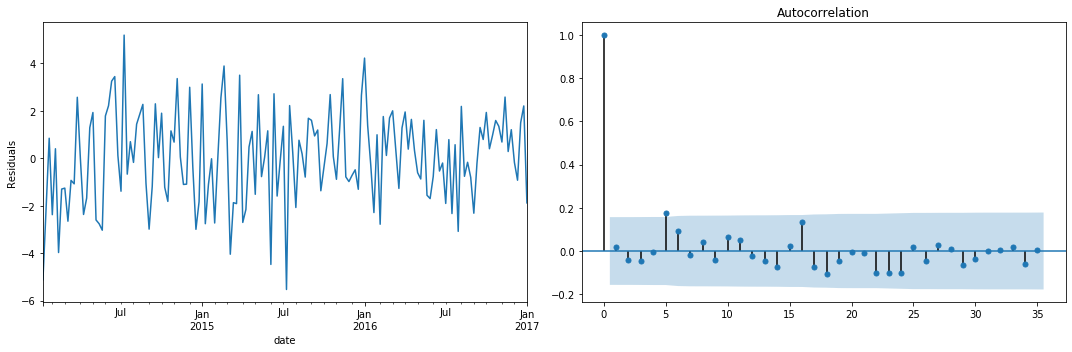

Критерий Стьюдента: p=0.851102
Критерий Дики-Фуллера: p=0.000000


In [25]:
plt.figure(figsize=[15, 5])
plt.subplot(121)
best_model.resid[53:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(122)
sm.graphics.tsa.plot_acf(best_model.resid[53:].values.squeeze(), lags=35, ax=ax)
plt.tight_layout()
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[53:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Хорошие остатки, одобряю.

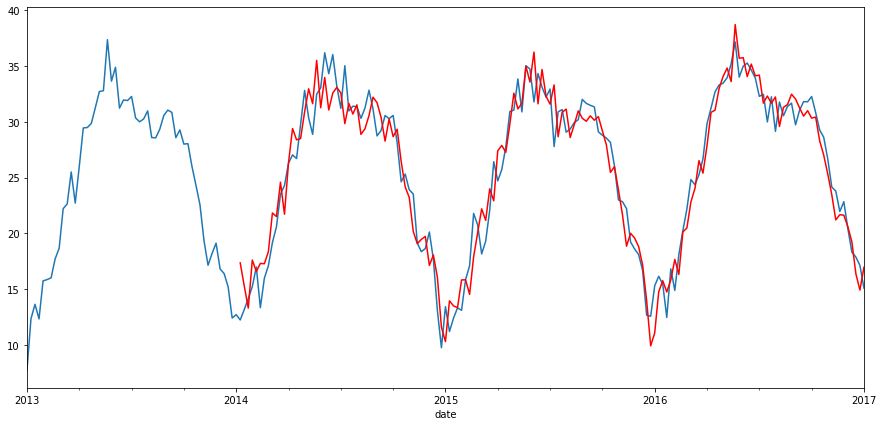

In [26]:
plt.figure(figsize=(15,7))
df.meantemp.plot()
best_model.fittedvalues[53:].plot(color='r')
plt.show()

Вот так оно выглядит. Это уже более интересно, график уже выглядит так, будто его сделал профессионал.

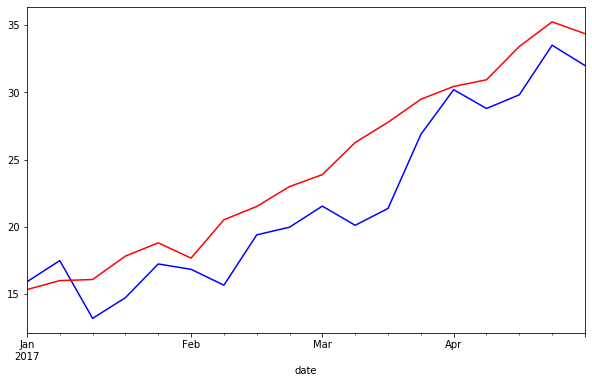

MSE = 9.909851175538911


In [27]:
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', parse_dates=['date'], index_col='date')
df_test = df_test.resample('W').mean()

y_test = df_test.meantemp
y_pred = best_model.predict(start=df_test.index.min(), end=df_test.index.max())

plt.figure(figsize=[10, 6])
df_test.meantemp.plot(c='b')
y_pred.plot(c='r')
plt.show()
print(f'MSE = {mean_squared_error(y_test, y_pred)}')

Это предсказание средненедельной температуры.

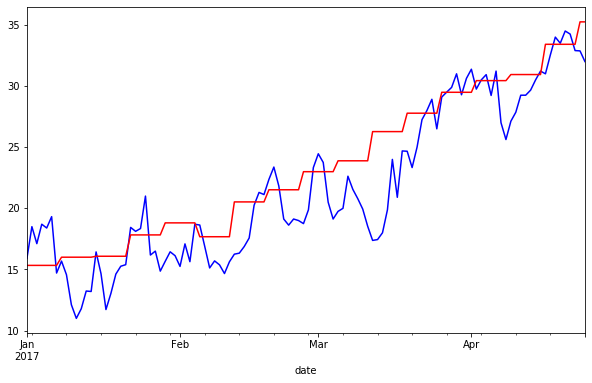

MSE = 8.269441118705892


In [28]:
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', parse_dates=['date'], index_col='date')

y_test = df_test.meantemp
y_pred = y_pred.resample('D').pad()[:len(y_test)]

plt.figure(figsize=[10, 6])
df_test.meantemp.plot(c='b')
y_pred.plot(c='r')
plt.show()

print(f'MSE = {mean_squared_error(y_test, y_pred)}')

А так выглядит предсказание по дням.

Вообще _MSE = 8.27_ - это крайне неплохой результат. И это учитывая, что мы предсказываем, сразу на несколько месяцев вперед, не используя реальные данные. То есть в теории, чем дольше такое предсказывание, тем больше будет ошибка. Но наша модель показывает себя очень хорошо.

Итак, мы подошли к концу первой части. Далее попробуем предсказывать ежедневную температуру. Для этого мы будем использовать преобразование Фурье.  

А теперь, вперед! К следующей части!